In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
import torch
import gc
import os

import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

/Users/aidangoeschel/Documents/UCI/CCNL/SemanticAnalysis/.venv/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [117]:
df1 = pd.read_csv("./datasets/hcV3-eventAnnots.csv")
# assume df1 is your original DataFrame

# 1) First, count how many annotators put each sentence into each bin
#    We’ll group by the sentence identifier + the bin label
vote_counts = (
    df1
    .groupby(['sent','rawEventAnnot', 'HippocorpusAssignmentId','sentIx'])
    .size()
    .reset_index(name='n_votes')
)

# 2) Find all (storyIx, sentIx) pairs that have any bin with >=5 votes
consensus = (
    vote_counts
    .loc[vote_counts['n_votes'] >= 3]  # threshold - e.g. 4/8 people have to agree what type of sentence it is
    .drop_duplicates()
    .reset_index(drop=True)
)

# add empty list
consensus['sequentiality'] = 0

consensus[consensus['HippocorpusAssignmentId']=='30IQTZXKALSNFY1G6POWA5M2MCJ0XG'].sort_values(['sent','n_votes'],ascending=[True,False]).drop_duplicates(subset='sent',keep='first').sort_values("sentIx")

,sent,rawEventAnnot,HippocorpusAssignmentId,sentIx,n_votes,sequentiality
4552,"Three months ago, I graduated college... finally.",major-expected,30IQTZXKALSNFY1G6POWA5M2MCJ0XG,0,6,0
1429,"I had my master's under my belt, teaching cred...",noEvent,30IQTZXKALSNFY1G6POWA5M2MCJ0XG,1,4,0
1164,I couldn't be prouder.,noEvent,30IQTZXKALSNFY1G6POWA5M2MCJ0XG,2,6,0
2128,I was finally done.,noEvent,30IQTZXKALSNFY1G6POWA5M2MCJ0XG,3,5,0
2082,I was able to get a cushy job at a private sch...,major-expected,30IQTZXKALSNFY1G6POWA5M2MCJ0XG,4,5,0
4103,"The pay was okay, but it was more about finall...",noEvent,30IQTZXKALSNFY1G6POWA5M2MCJ0XG,5,6,0
4615,"Unfortunately, we took budget cuts.",major-surprising,30IQTZXKALSNFY1G6POWA5M2MCJ0XG,6,6,0
2244,"I was the last hired, so I was the first fired.",major-surprising,30IQTZXKALSNFY1G6POWA5M2MCJ0XG,7,5,0
1465,I had to accept a teaching job at a public sch...,major-expected,30IQTZXKALSNFY1G6POWA5M2MCJ0XG,8,4,0
4102,"The pay is horrendous, it's almost like the go...",noEvent,30IQTZXKALSNFY1G6POWA5M2MCJ0XG,9,5,0


In [118]:
consensus.shape

(5328, 6)

In [119]:
sequentialities = []

for i in range(1, 10):
    sequentialities.append(pd.read_csv(f"./outputs/llama-70b-quantized/{i}/240.csv"))

In [120]:
for i in range(len(consensus)):
    assignmentId = consensus.loc[i, "HippocorpusAssignmentId"]

    # get the story length according to my model
    story_seq_values = eval(sequentialities[0].loc[sequentialities[0]['AssignmentId'] == assignmentId]["sentence_total_sequentialities"].to_list()[0])
    story_len = len(story_seq_values)

    # compare to story length from dataset
    if consensus[consensus['HippocorpusAssignmentId']==assignmentId].sort_values(['sent','n_votes'],ascending=[True,False]).drop_duplicates(subset='sent',keep='first').shape[0] == story_len:
        total = 0
        sentIx = int(consensus.loc[i, "sentIx"])
        
        # print(f"[{i}] sentIx = {sentIx}, story_seq_values[sentIx] = {story_seq_values[sentIx]}")
        try:
            consensus.loc[i, "sequentiality"] += story_seq_values[sentIx]
        except IndexError:
            print(sentIx, story_len)
            continue

consensus["sequentiality"] /= 8.0
consensus

/var/folders/k_/22wd5tt52nqbzmr9k7yzq1xm0000gn/T/ipykernel_85343/2971216929.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.0876611328125' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  consensus.loc[i, "sequentiality"] += story_seq_values[sentIx]


24 24
24 24
26 26


,sent,rawEventAnnot,HippocorpusAssignmentId,sentIx,n_votes,sequentiality
0,"'And as she watched, joyful tears slipped onto...",minor-expected,3I7DHKZYGOM5AJWW31OMLTILC4GF5W,14,5,0.000000
1,'Lonesome Dove' is the name of a near ghost to...,major-surprising,3QEMNNSB2YLNZ3WJ0O8TVDTXERTD79,3,3,0.000000
2,'Lonesome Dove' is the name of a near ghost to...,noEvent,3QEMNNSB2YLNZ3WJ0O8TVDTXERTD79,3,5,0.000000
3,(I was worried about health effects for my boy!),noEvent,3K4J6M3CXFF8UP489HLLBPYJ2EVAG5,8,7,0.000000
4,(This after talking to her for over 2 years o...,major-surprising,3Z4AIRP3C7ZNMNMY28SWOA5BE5EX1S,24,3,-0.010958
...,...,...,...,...,...,...
5323,when we finally got to his college apartment o...,noEvent,34YB12FSQZA9WQDX6KBQKGTKM9DGM8,8,3,0.006663
5324,which I use o train people on how to become mo...,noEvent,3FK0YFF9P02B4AX197B37DF6IXUVVM,12,7,0.058229
5325,you hardly ever forget what you want to say an...,noEvent,3FK0YFF9P02B4AX197B37DF6IXUVVM,16,7,0.066111
5326,“Julie and the girls at Jet Set Getaways have ...,major-expected,308Q0PEVB9Z8LX0Y7Z7O060G137I98,0,3,0.000000


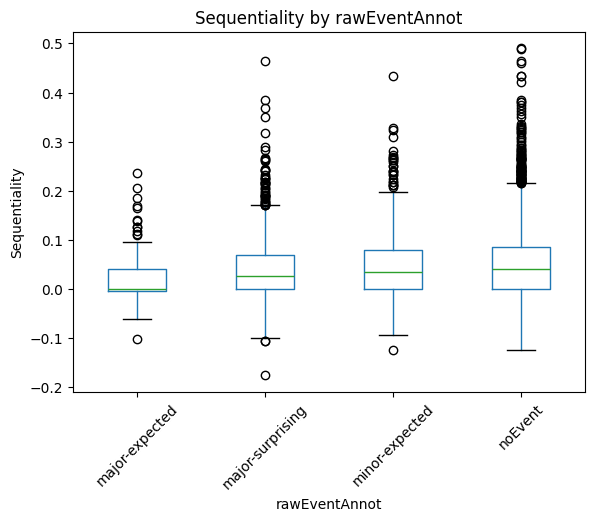

In [121]:
import matplotlib.pyplot as plt

consensus.boxplot(column='sequentiality', by='rawEventAnnot', grid=False)
plt.title('Sequentiality by rawEventAnnot')
plt.suptitle('')  # remove default subtitle
plt.xlabel('rawEventAnnot')
plt.ylabel('Sequentiality')
plt.xticks(rotation=45)  # rotate labels if needed
plt.show()

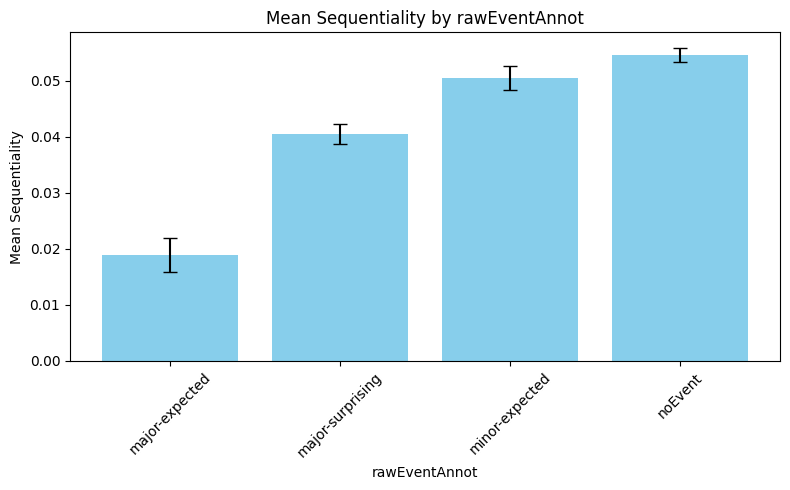

In [135]:
# Calculate means and standard errors per group
group_stats = consensus.groupby('rawEventAnnot')['sequentiality'].agg(['mean', 'sem']).reset_index()

# Create bar plot with error bars
plt.figure(figsize=(8,5))
plt.bar(group_stats['rawEventAnnot'], group_stats['mean'], yerr=group_stats['sem'], capsize=5, color='skyblue')

plt.title('Mean Sequentiality by rawEventAnnot')
plt.xlabel('rawEventAnnot')
plt.ylabel('Mean Sequentiality')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [122]:
print(consensus.groupby('rawEventAnnot')['sequentiality'].describe())

                   count      mean       std       min       25%       50%  \
rawEventAnnot                                                                
major-expected     241.0  0.018912  0.047119 -0.102296 -0.003998  0.000000   
major-surprising  1164.0  0.040551  0.061213 -0.176694  0.000000  0.025157   
minor-expected     856.0  0.050431  0.063111 -0.124593  0.000000  0.033747   
noEvent           3067.0  0.054633  0.067662 -0.124593  0.000000  0.040568   

                       75%       max  
rawEventAnnot                         
major-expected    0.040958  0.235229  
major-surprising  0.067988  0.463867  
minor-expected    0.079478  0.433472  
noEvent           0.085918  0.490356  


In [81]:
print(consensus.dtypes)

sent                        object
rawEventAnnot               object
HippocorpusAssignmentId     object
sentIx                       int64
n_votes                      int64
sequentiality              float64
dtype: object


## T Test

In [125]:
tukey = pairwise_tukeyhsd(endog=consensus['sequentiality'],
                          groups=consensus['rawEventAnnot'],
                          alpha=0.05)
print(tukey.summary())

          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1           group2      meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------------
  major-expected major-surprising   0.0216    0.0  0.0099 0.0334   True
  major-expected   minor-expected   0.0315    0.0  0.0194 0.0437   True
  major-expected          noEvent   0.0357    0.0  0.0246 0.0469   True
major-surprising   minor-expected   0.0099 0.0039  0.0024 0.0174   True
major-surprising          noEvent   0.0141    0.0  0.0084 0.0198   True
  minor-expected          noEvent   0.0042 0.3354 -0.0022 0.0106  False
-----------------------------------------------------------------------


In [127]:
# 1. How many observations per annotation?
print(consensus.groupby('rawEventAnnot').size())

# 2. What are the unique sequentiality values?
print(consensus['sequentiality'].unique())


rawEventAnnot
major-expected       241
major-surprising    1164
minor-expected       856
noEvent             3067
dtype: int64
[ 0.         -0.01095764 -0.01216395 ...  0.00666254  0.05822923
  0.06611053]


In [132]:
import pandas as pd
from scipy.stats import f_oneway

# group the sequentiality values by annotation
groups = [grp["sequentiality"].values 
          for _, grp in consensus.groupby("rawEventAnnot")]

# run ANOVA
f_stat, p_val = f_oneway(*groups)
print(f"F = {f_stat:.5f}, p = {p_val}")

F = 31.78326, p = 2.3473107736272128e-20


In [24]:
len(["Three months ago, I graduated college... finally. ",
"I had my master's under my belt, teaching credentials in line. ",
"I couldn't be prouder. ",
"I was finally done. ",
"I was able to get a cushy job at a private school for all grades K-12. ",
"The pay was okay, but it was more about finally being able to do what I love, what I spent so long trying to achieve. ",
"Unfortunately, we took budget cuts. ",
"I was the last hired, so I was the first fired. ",
"I had to accept a teaching job at a public school after getting used to my dreamy, safe, private school job. ",
"The pay is horrendous, it's almost like the government doesn't want kids to learn anything. ",
"I had to buy most of the supplies, and some of the kids are so poor, I ended up having to buy supplies for the kids to even be able to learn. ",
"Cheap backpacks and notebooks apparently add up. ",
"I thought my student loans were bad... these credit card bills as a public school teacher may kill me before I even get a chance to get a raise in 10 years. ",
"But these kids... They need me. ",
"I feel like I am right where I am supposed to be, helping these kids. ",
"Even if I end up having to get a part-time job on top of this to make ends meet."])

16


History Length 1:
Imagined: 80 data points
Retold: 80 data points
Recall: 80 data points

History Length 2:
Imagined: 80 data points
Retold: 80 data points
Recall: 80 data points

History Length 3:
Imagined: 80 data points
Retold: 80 data points
Recall: 80 data points

History Length 4:
Imagined: 80 data points
Retold: 80 data points
Recall: 80 data points

History Length 5:
Imagined: 80 data points
Retold: 80 data points
Recall: 80 data points

History Length 6:
Imagined: 80 data points
Retold: 80 data points
Recall: 80 data points

History Length 7:
Imagined: 80 data points
Retold: 80 data points
Recall: 80 data points

History Length 8:
Imagined: 80 data points
Retold: 80 data points
Recall: 80 data points

History Length 9:
Imagined: 80 data points
Retold: 80 data points
Recall: 80 data points


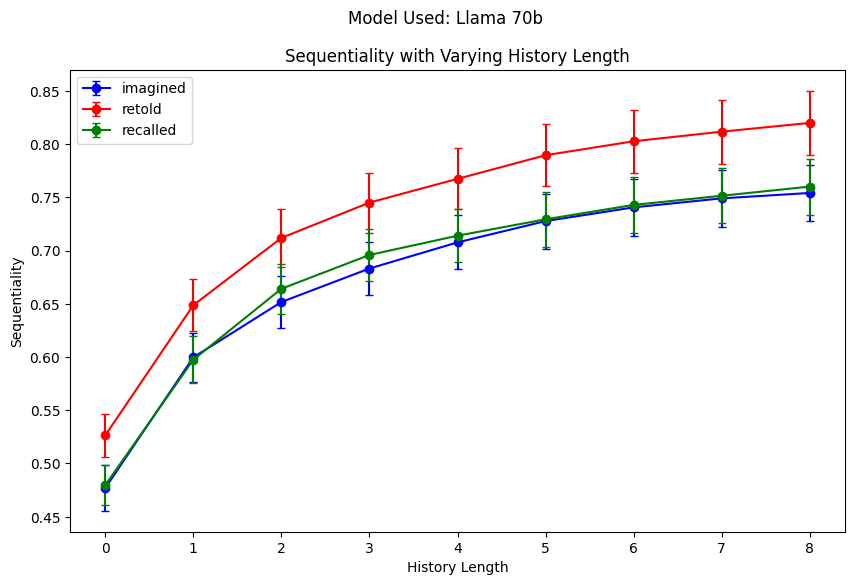

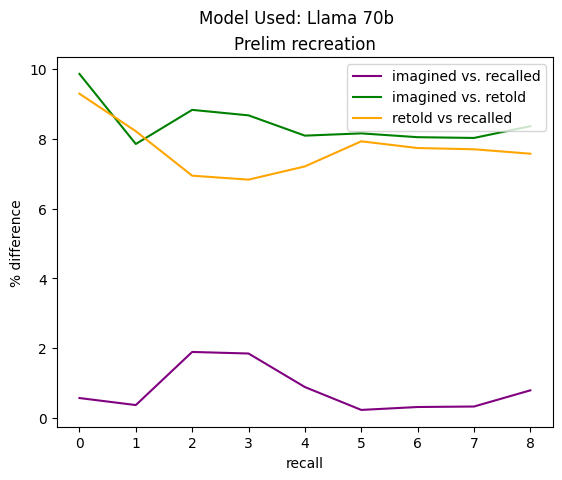

In [134]:
from main import generate_plots


generate_plots("./outputs/llama-70b-quantized", "240.csv", model_name="Llama 70b")

In [136]:
data = np.array([0.019514415929193726, 0.03268195782135596, 0.2853376039936168, 0.04427520861818458, 0.0886748126665959, 0.0019305151271675274, 0.059695011057404115, 0.07664769813142734, 0.03524054201607493, 0.0011911923772097194, 0.8161114561171785, 0.14920567592370026, 0.16414578885266515, 0.659209605481325, 0.00317356154805102, 0.3112705441513659, 0.05273782887158226, 0.04832218005922437, 0.038029046650207954, 0.0119634437566419, 1.0919105633578717e-07, 0.1110149648165206, 0.003832983298742897, 0.28418584941942127, 0.008298874546165689, 0.0002702193531422569, 0.0002994605410892407, 0.035270049629034246, 0.0006718107997326414, 0.1192364315163904, 0.0002755561006686231, 0.04089802600047769, 0.004151369791566819, 0.02881592966222691, 0.012900228801712542, 0.3897757340811846, 0.677967320002329, 0.09358125462231112, 0.008724627744134789, 0.17758970418973627, 0.1811119325445559, 0.0029191173604423, 0.10422317890167097, 0.2298583656443192, 0.006526553232387927, 0.09172449278372351, 0.045767450632163795, 0.006117305719532605, 0.04476253697731352, 0.12790564599714788, 0.0234296033949096, 0.3367189825028699, 0.06202529681418169, 0.29741438472433857, 0.08505318335500567, 0.9475191178615657, 0.38523972692728786, 0.630256810749999, 0.2849352347931697, 0.2573303336352393, 0.005208366503550183, 0.3107786879111586, 0.12133205310040447, 0.1314008942201078, 0.03223050957590637, 0.019239819736740802, 0.32605848997457243, 0.009885737562961412, 0.0035748564445002634, 0.07580279714787216, 0.03858312154990079, 0.03368054802644731, 6.116331218677975e-08, 0.05301906914894012, 0.27557960104920015, 0.6458349120309066, 0.007432033834835867, 0.00021311771236145026, 0.06017938337407444, 0.017816195821668192, 0.09815287017728733, 0.15058378886028775, 0.0009488227354535021, 0.1239638590671052, 0.0006827116024818835, 0.9964460058671325, 0.0006594772433622457, 0.09776391010640964, 0.0007801772686776304, 0.0016244074951030781, 0.0030959087206497743, 0.10779822899201964, 0.0028324781726693335, 0.0021292793576309726, 0.04180328793726656, 0.008065280772558404, 0.008256801575392183, 0.012829667619310281, 0.06669148978976708, 0.05453974071336285, 9.613243499273551e-06, 0.08456379386366486, 4.908095466443647e-05, 0.00332810434237207, 0.11075022169781397, 0.0042061286397581535, 0.0004914389387426654, 0.026253930452195, 0.3354967968780438, 0.03700075013318034, 0.002491875216937326, 0.46814645958629586, 0.00021031680425371074, 0.00010164706823206983, 0.00011706107127102383, 0.01756881624427981, 0.001363213434476503, 0.002018117712661061, 0.000957256221565307, 0.01860949664903218, 0.0706336123410096, 0.025568579024034522, 0.023732578051412868, 0.006374173018794134, 0.8321308099136328, 0.014086456898941554, 0.6696496312477552, 0.261864320305989, 0.05571578644533319, 0.06790946376950475, 0.1208958277368683, 0.03103409730476577, 0.002631636944647598, 0.28044514219475675, 0.04572409069535913, 0.05451588765425154, 0.0022137027647515847, 0.010145853193428984, 0.0019127183894696157, 0.003949342787178935, 0.3316024897244753, 0.18190245722344994, 0.13162201250091124, 0.005884634986034494, 0.018793263098551095, 0.40229755471906653, 0.020141873759214893, 0.03683650326016057, 0.12124670379340613, 0.02885778510387297, 0.011341201845719826, 0.6200146952939523, 0.0893018186314793, 0.0396269893814138, 0.05005585151644781, 0.06784436945617865, 0.13040957813797716, 3.7263533683448236e-09, 0.7230638070231776, 0.005785863547016979, 0.008162989297066207, 8.586003281498038e-05, 1.5108440514898249e-05, 0.003452486711335109, 0.019756428203975617, 2.3351213395386238e-05, 0.0007210913860099824, 0.0938737751142569, 0.06607619165296522, 0.0006870788889960382, 0.38261583826691137, 0.03692643307519182, 0.6908899977436943, 0.4434001397617274, 0.0006911191579505887, 0.00025087584873931246, 0.3479708232180138, 0.01506599427272734, 0.1887284100365148, 0.07336992475978153, 0.15209300628601746, 0.08990144659614854, 0.0006981301514258177, 0.9578906871765396, 0.038550550572249424, 0.017201802853731143, 0.1268737167703588, 0.02284393248462789, 0.19091123254121733, 0.5712966811179644, 0.007519425825159976, 1.4676687683939484e-06, 0.1354236365280374, 0.4754245423652599, 0.988921998919247, 3.5851351563849973e-07, 0.01599849154649246, 0.05570824513338241, 0.17742261264353187, 0.010277362783666632, 0.12850721273716598, 0.9962545994667037, 0.15944484529588035, 0.08773114636928124, 0.19852341575471033, 0.13451459640769872, 0.7273809310832835, 0.003229698295389451, 0.011141500407884952, 0.013411454741874199, 0.011919407934864826, 0.39303700512884004, 6.119587864276193e-05, 0.004524609955958704, 0.17787726189958034, 0.0007629534173654583, 0.005976444314686856, 0.15537852927438378, 0.00030282089408468566, 0.0016157450562205614, 0.016729696143279488, 0.036928593182184694, 0.15639431349478866, 0.0002316844074512238, 0.00029142871341405433, 0.045126455293161616, 0.12761285012651344, 0.9807301322224806, 0.001020726401775678, 0.08593018407703505, 0.007943351047593208, 0.00012641792933094833, 0.010677998753877531, 0.00937548302560299, 0.15299706399962465, 0.013541193457971987, 0.017234699626091046, 0.10081139668206138, 0.13861885364479393, 0.19077228270420704, 0.11730027648661201, 0.9241784462723589, 0.020343168805575525, 0.0008531869962118398, 0.08156988007850573, 0.0010901580147295044, 0.0006472973350614729, 0.15575249593186127, 0.7045932372807048, 0.02694690534090932, 0.009610055497407293, 0.8696825527255583, 0.9482874238628325, 2.1882323840177122e-05, 0.05246680550280758, 3.4446046597620235e-05])

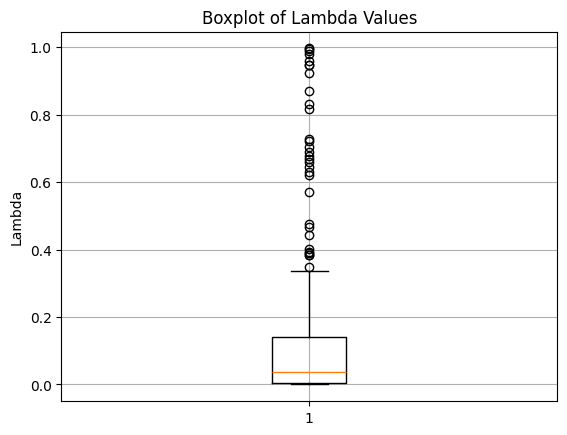

In [146]:
import matplotlib.pyplot as plt

# Assuming 'data' is your list of lambda values



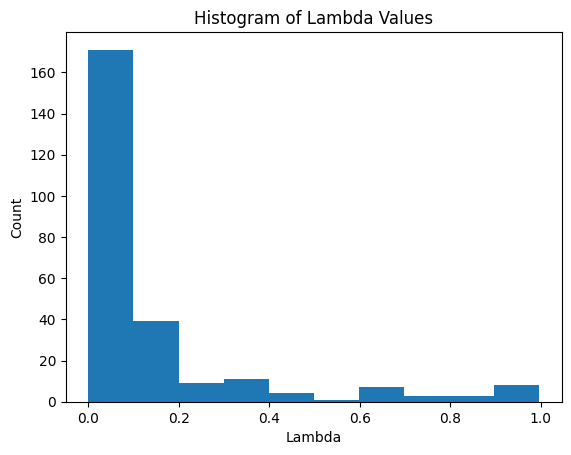

In [9]:
df = pd.read_csv("./datasets/hcV3-stories.csv")
print(f"overall dataframe shape {df.shape}")
print(f"number of unique topics {df["mainEvent"].unique().shape[0]}")

overall dataframe shape (6854, 23)
number of unique topics 6323


In [ ]:
# Group the dataframe by the 'mainEvent' column and count the number of unique 'AssignmentId's for each group
multi_story_topics = df.groupby('mainEvent')['AssignmentId'].nunique()

# Filter to keep only those 'mainEvent' entries that have more than 1 unique 'AssignmentId' (i.e., appear in multiple stories)
multi_story_topics = multi_story_topics[multi_story_topics > 1].index

# Filter the original dataframe to keep only rows where 'mainEvent' is one of the multi-story topics identified above
result_df = df[df['mainEvent'].isin(multi_story_topics)]


result_df.head 

,AssignmentId,WorkTimeInSeconds,WorkerId,annotatorAge,annotatorGender,annotatorRace,distracted,draining,frequency,importance,...,mostSurprising,openness,recAgnPairId,recImgPairId,similarity,similarityReason,story,stressful,summary,timeSinceEvent
12,35LDD5557BQEYC9GWBW5I8LCG5AKMA,4925,4RDYARRP,30.0,man,black,3.0,4.0,3.0,3.0,...,me going to the wedding,0.250,304SM51WA4QG34IRAVFYVE1SAOBSB3,NaN,NaN,NaN,My Cousin's WeddingWe went to my cousin’s wedd...,4.0,My life was endangered for doing research on p...,1.800000e+02
27,308XBLVESJQ42PIEV6FT54WWN37BRA,786,7SYNT0P0,30.0,man,white,1.0,4.0,5.0,5.0,...,Finding out it was a Girl,0.500,308XBLVESJQ42PIEV6FT54WWN37BRA,308XBLVESJQ42PIEV6FT54WWN37BRA,NaN,NaN,The biggest thing to happen to me is finding o...,4.0,I found out I am going to be a father. My wif...,6.666667e+29
51,354GIDR5ZCSFI8V53DZP1RZQQAG00P,394,OYS9492Q,35.0,woman,white,1.0,1.0,2.0,4.0,...,I was invited to go on a free trip.,-0.625,30BXRYBRP5JJ1Y2MUSZVEE7B3H5WHT,NaN,NaN,NaN,At the beginning of this year my mother in law...,1.0,I got to go on a free trip to Disney World wit...,1.500000e+02
52,30BXRYBRP5JJ1Y2MUSZVEE7B3H5WHT,1121,OYS9492Q,35.0,woman,white,1.0,2.0,3.0,4.0,...,I was invited to go on a free trip.,-0.625,30BXRYBRP5JJ1Y2MUSZVEE7B3H5WHT,NaN,NaN,NaN,A recent memorable event in my life was when I...,2.0,I got to go on a free trip to Disney World wit...,1.200000e+02
61,30H4UDGLT34F936W931DEP7B965PMM,1059,RA7SBCFF,30.0,man,hisp,1.0,2.0,5.0,5.0,...,my boss offered me a supervisor position of th...,1.000,NaN,30H4UDGLT34F936W931DEP7B965PMM,NaN,NaN,"Dear diary, today was the best day of my life....",1.0,My boss call me to discuss some projects at wo...,9.000000e+01


In [20]:
result_df.to_csv("./datasets/hcV3-multi-topic.csv")

In [30]:
topic_counts = result_df.groupby('mainEvent')['memType'].nunique()
all_three_topics = topic_counts[topic_counts == 3].index
all_three_df = result_df[result_df['mainEvent'].isin(all_three_topics)]

all_three_df["mainEvent"].unique()

array(['my wedding day.', 'losing my job.', 'my child being born.',
       'getting a new job', 'getting a promotion at work',
       'the birth of my daughter', 'getting a promotion',
       'my daughter coming out', "my friend's wedding.",
       "my sister's wedding.", "about my cousin's wedding",
       'my cat dying.', 'the death of my uncle', 'my wedding.',
       'a birthday party', 'A family reunion'], dtype=object)

In [28]:
all_three_df.to_csv("./datasets/hcV3-tri-topic.csv")

In [32]:
cat_stories = result_df[result_df['mainEvent'] == 'my cat dying.']
cat_stories

,AssignmentId,WorkTimeInSeconds,WorkerId,annotatorAge,annotatorGender,annotatorRace,distracted,draining,frequency,importance,...,mostSurprising,openness,recAgnPairId,recImgPairId,similarity,similarityReason,story,stressful,summary,timeSinceEvent
1599,3300DTYQT332XRFYSISJ1MSC60EEQS,1082,DT3XNTBX,35.0,woman,black,2.0,5.0,3.0,5.0,...,my other cat died days later.,0.875,39JEC7537VNF51R1IQGYHLRHRD8VCL,NaN,NaN,NaN,It's been 6 months since my beloved cat dyed. ...,3.0,My 17 year old cat died in April. His eutheniz...,1.800000e+02
4629,3PJUZCGDJ72FWROLYDVXNH6197J89G,1616,9YW2CQ6Z,25.0,man,white,1.0,4.0,3.0,4.0,...,he degraded so quickly despite the treatments ...,0.625,NaN,3PJUZCGDJ72FWROLYDVXNH6197J89G,NaN,NaN,Today was definitely not the best of days. Aft...,3.0,My elderly cat was sick and had a turn for the...,4.444444e+29
4736,3PPTZCWALR608M6UO56WMWTV7PVQZZ,597,FK2G760J,35.0,man,white,1.0,1.0,NaN,4.0,...,having my ashes interred near the cat burial g...,0.500,NaN,3Q5C1WP23NNEK42OW291WRERBW415S,5.0,fairly,Ms. Kitty died and it is horrible shame and I ...,1.0,My dear cat died and I miss her an think about...,1.500000e+02


In [33]:
cat_stories.to_csv("./datasets/hcV3-cat.csv")